<a href="https://colab.research.google.com/github/020/020.github.io/blob/master/14_09_22_Exp_1_Hour_Bed_Occupancy_TS_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px


In [128]:
data = pd.read_csv("/content/rddp_beds_occupancy.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2514 non-null   object 
 1   occupancy  2514 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.4+ KB


In [129]:
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
data.head(3)

,date,occupancy
0,2022-05-11 00:00:00,0.79
1,2022-05-11 01:00:00,0.79
2,2022-05-11 02:00:00,0.80


In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2514 non-null   datetime64[ns]
 1   occupancy  2514 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


In [131]:
data.tail(3)

,date,occupancy
2511,2022-08-23 21:00:00,0.80
2512,2022-08-23 22:00:00,0.81
2513,2022-08-23 23:00:00,0.81


In [132]:
# Renaming columns
#data = data.rename({'occupied': 'occupancy'}, axis = 1)

# Setting Date as index
data = data.set_index('date')

In [133]:
print(data.isnull().sum())

occupancy    0
dtype: int64


In [8]:
# There is one missing value in the data, we fill it with previous day's occupancy.

data = data.fillna(method = 'pad')
print(data.isnull().sum())

gas_price    0
dtype: int64


In [134]:
fig = px.line(data, title = 'Bed Occupancy', template = 'plotly_dark')
fig.show()

In [135]:
fig = px.histogram(data, x = "occupancy", template = 'plotly_dark')
fig.show()

In [137]:
data = data.sort_values(by = 'date')

train = data['2022-05-11 0:00': '2022-07-30 23:00']  
test = data['2022-07-31 0:00': '2022-08-23 23:00'] 

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test))

Length of Train Data:  1944
Length of Test Data:  570


In [138]:
train.head(2)

,occupancy
date,
2022-05-11 00:00:00,0.79
2022-05-11 01:00:00,0.79


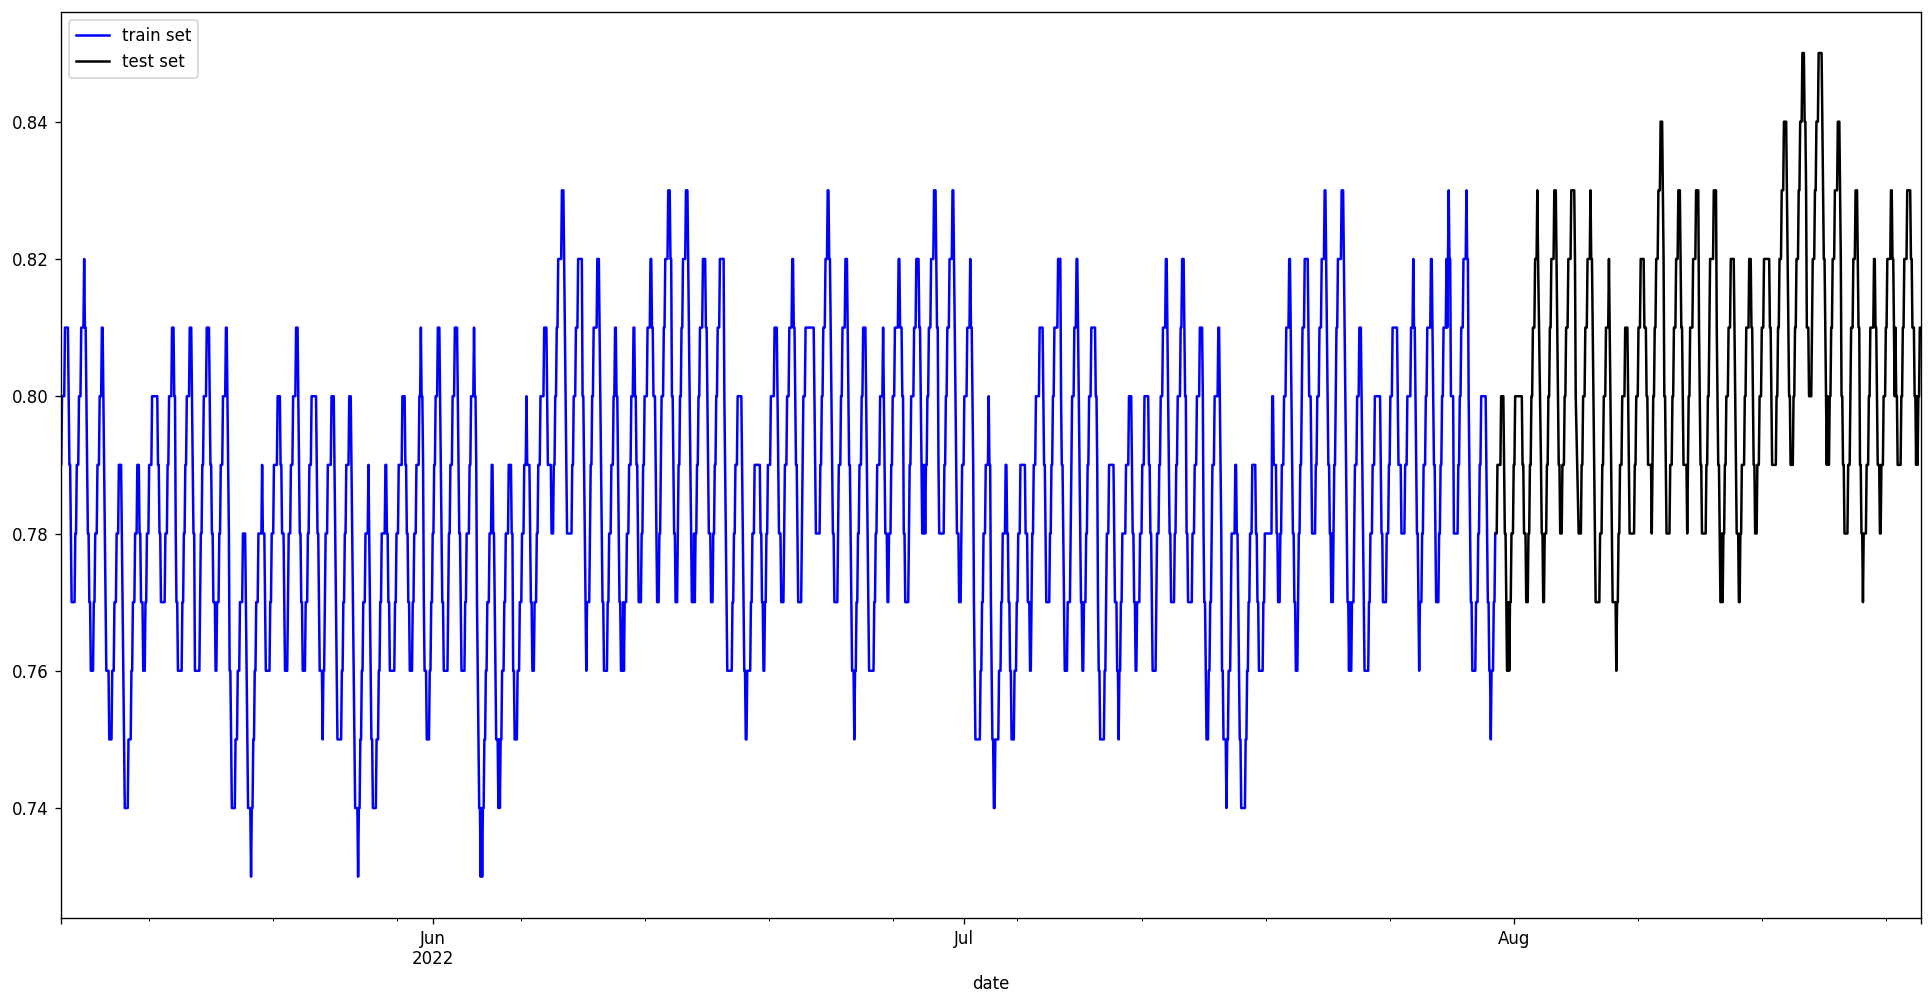

In [139]:
ax = train.plot(figsize = (20, 10), color = 'b')
test.plot(ax = ax, color = 'black')
plt.legend(['train set', 'test set'])
plt.show()

In [140]:
model = sm.tsa.arima.ARIMA(train, order = (1, 2, 1))
arima_model = model.fit() 
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:              occupancy   No. Observations:                 1944
Model:                 ARIMA(1, 2, 1)   Log Likelihood                7044.542
Date:                Wed, 14 Sep 2022   AIC                         -14083.083
Time:                        02:01:41   BIC                         -14066.369
Sample:                    05-11-2022   HQIC                        -14076.937
                         - 07-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3196      0.031    -10.178      0.000      -0.381      -0.258
ma.L1         -0.4779      0.028    -17.027      0.000      -0.533      -0.423
sigma2      4.135e-05   1.47e-06     28.188      0.0

In [141]:
yp_train = arima_model.predict(start = 0, end = (len(train)-1))
yp_test = arima_model.predict(start = 0, end = (len(test)-1)) 

print("Train Data:\nMean Square Error: {}".format(mean_squared_error(train, yp_train)))
print("\nTest Data:\nMean Square Error: {}".format(mean_squared_error(test, yp_test)))

Train Data:
Mean Square Error: 0.0004426406881329087

Test Data:
Mean Square Error: 0.0029765151464735164


In [142]:
print(yp_test)

2022-05-11 00:00:00    0.000000
2022-05-11 01:00:00    1.185000
2022-05-11 02:00:00    0.790000
2022-05-11 03:00:00    0.804007
2022-05-11 04:00:00    0.804945
                         ...   
2022-06-03 13:00:00    0.761318
2022-06-03 14:00:00    0.747434
2022-06-03 15:00:00    0.738774
2022-06-03 16:00:00    0.729414
2022-06-03 17:00:00    0.731745
Freq: H, Name: predicted_mean, Length: 570, dtype: float64


In [157]:
window_size = 14

x_train = []
y_train = []

for i in range(window_size, len(train)):
    x_train.append(train.iloc[i-window_size:i, 0])
    y_train.append(train.iloc[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(1930, 14, 1) (1930,)


In [194]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

tf.keras.backend.clear_session()

lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(128, return_sequences=True,input_shape=[14,1]))
lstm_model.add(tf.keras.layers.LSTM(128, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1))


lstm_model.compile(optimizer="adam", loss="mean_squared_error")

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [195]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 7)

history = lstm_model.fit(x_train, y_train, epochs = 30, 
                         batch_size = 5, 
                         verbose = 1, shuffle = False, 
                         callbacks = [early_stopping])

Epoch 1/30
386/386 [==============================] - 11s 19ms/step - loss: 0.0076
Epoch 2/30
386/386 [==============================] - 8s 22ms/step - loss: 6.3043e-04
Epoch 3/30
386/386 [==============================] - 9s 24ms/step - loss: 5.8678e-04
Epoch 4/30
386/386 [==============================] - 8s 22ms/step - loss: 5.3109e-04
Epoch 5/30
386/386 [==============================] - 7s 19ms/step - loss: 4.8130e-04
Epoch 6/30
386/386 [==============================] - 7s 19ms/step - loss: 4.3922e-04
Epoch 7/30
386/386 [==============================] - 7s 19ms/step - loss: 4.0235e-04
Epoch 8/30
386/386 [==============================] - 7s 19ms/step - loss: 3.6408e-04
Epoch 9/30
386/386 [==============================] - 7s 19ms/step - loss: 3.1774e-04
Epoch 10/30
386/386 [==============================] - 8s 21ms/step - loss: 2.2845e-04
Epoch 11/30
386/386 [==============================] - 7s 19ms/step - loss: 1.1531e-04
Epoch 12/30
386/386 [==============================] - 

In [196]:
yp_train = lstm_model.predict(x_train)
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'pred'}, inplace = True); 
a.index = train.iloc[window_size:].index
train_compare = pd.concat([train.iloc[window_size:], a], 1)

In [197]:
train_compare.head(3)

,occupancy,pred
date,,
2022-05-11 14:00:00,0.78,0.778799
2022-05-11 15:00:00,0.77,0.772692
2022-05-11 16:00:00,0.77,0.765748


In [198]:
train_compare.tail(3)

,occupancy,pred
date,,
2022-07-30 21:00:00,0.77,0.768349
2022-07-30 22:00:00,0.77,0.775276
2022-07-30 23:00:00,0.78,0.780162


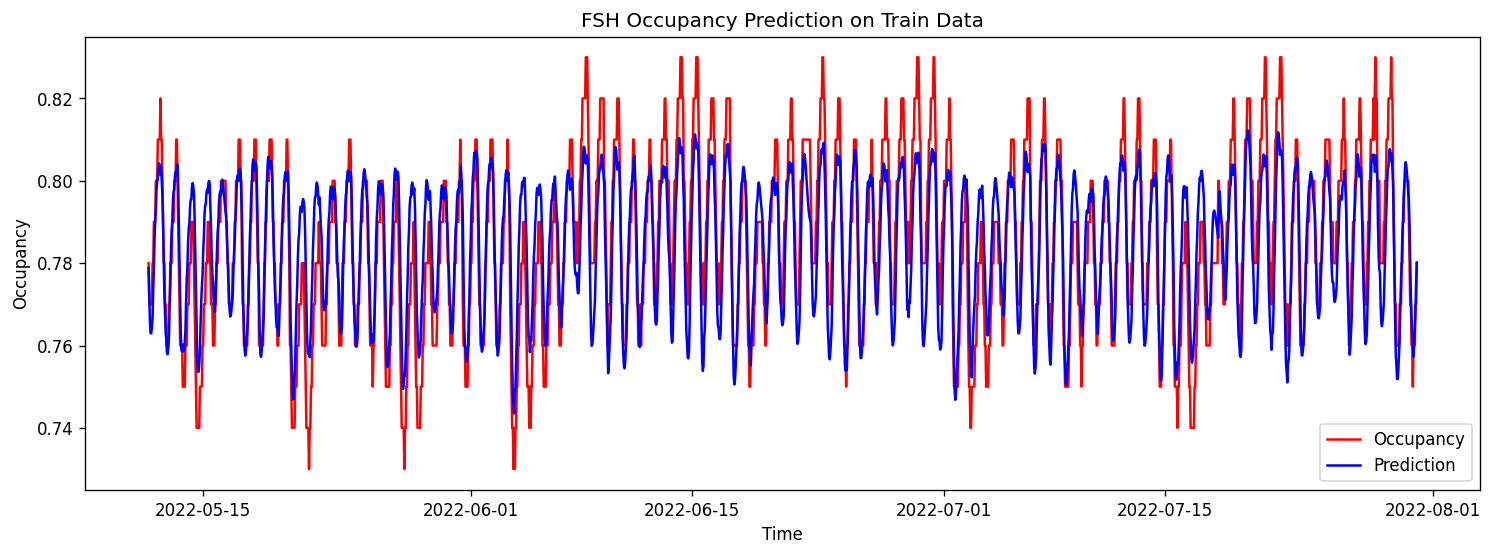

In [199]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['occupancy'], color = 'red', label = "Occupancy")
plt.plot(train_compare['pred'], color = 'blue', label = 'Prediction')
plt.title("FSH Occupancy Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.legend(loc = 'best')
plt.show()

In [200]:
dataset_total = pd.concat((train, test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)- window_size:].values
inputs = inputs.reshape(-1, 1)

x_test = []
y_test = []
for i in range (window_size, len(test)+window_size): #Test+15
    x_test.append(inputs[i-window_size:i, 0])
    y_test.append(train.iloc[i, 0])
      
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = lstm_model.predict(x_test)

In [201]:
b = pd.DataFrame(pred_price)
b.rename(columns = {0: 'pred'}, inplace = True); 
b.index = test.index
test_compare = pd.concat([test, b], 1)

In [202]:
test_compare.head(3)

,occupancy,pred
date,,
2022-07-31 00:00:00,0.78,0.787261
2022-07-31 01:00:00,0.78,0.791474
2022-07-31 02:00:00,0.79,0.793210


In [203]:
test_compare.tail(3)

,occupancy,pred
date,,
2022-08-23 21:00:00,0.80,0.776584
2022-08-23 22:00:00,0.81,0.780516
2022-08-23 23:00:00,0.81,0.787545


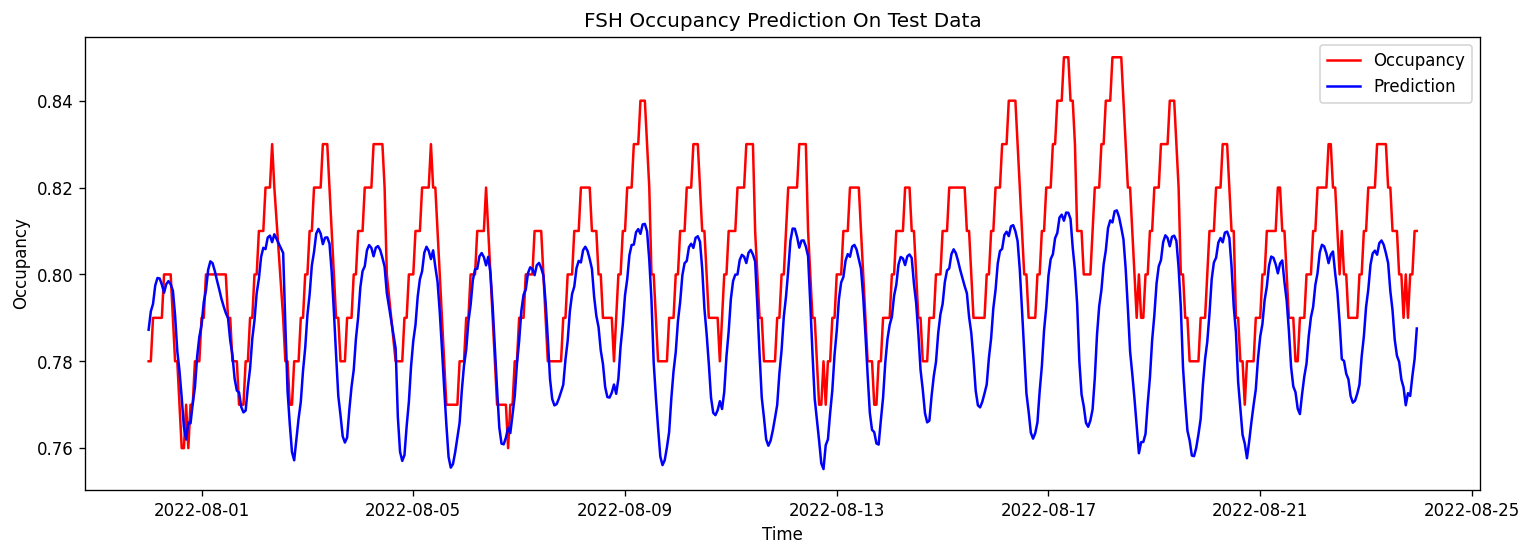

In [204]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['occupancy'], color = 'red', label = "Occupancy")
plt.plot(test_compare['pred'], color = 'blue', label = 'Prediction')
plt.title("FSH Occupancy Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.legend(loc = 'best')
plt.show()

In [170]:
mse_train = mean_squared_error(train_compare['occupancy'], train_compare['pred'])
mse_test = mean_squared_error(test_compare['occupancy'], test_compare['pred'])

r2_train = r2_score(train_compare['occupancy'], train_compare['pred'])
r2_test = r2_score(test_compare['occupancy'], test_compare['pred'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 0.00022440485922130247
R Square: 0.46332143911073476

Test Data:
MSE: 0.00033416336850312955
R Square: 0.08396715512896336


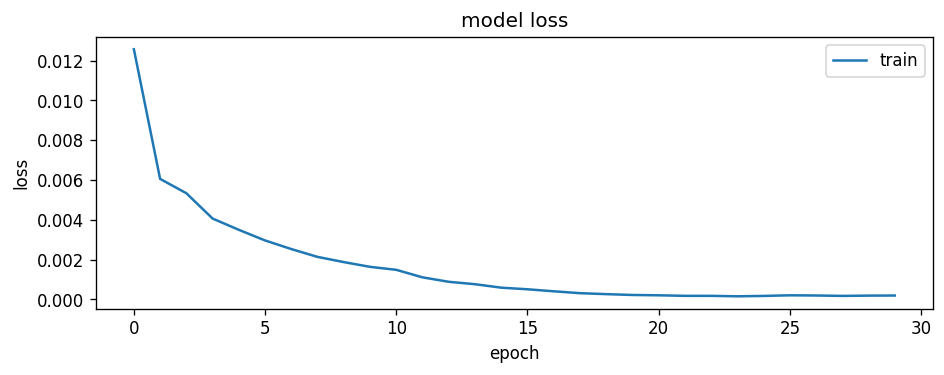

In [171]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [172]:
forecast = pd.DataFrame({'date': pd.date_range(start = '1/1/2020', end = '15/1/2020')}) 

inputs = test[len(test) - window_size: ].values

for i in range(window_size, len(forecast)): 
    inputs = inputs.T
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    pred_price = lstm_model.predict(inputs[:,i-window_size:i])
    inputs = np.append(inputs, pred_price)
    inputs = np.reshape(inputs, (inputs.shape[0], 1))

forecast['pred'] = inputs
forecast = forecast.set_index('date')

In [173]:
forecast.reset_index(inplace = True)

fig = px.line(forecast, x = "date", y = "pred", title = 'Occupancy Forecasting', template = 'plotly_dark')
fig.show()